
## Chapter 3 [Imaging](Ch3-Imaging.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Registration of Images in a Stack 


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes







## First we import the usual libraries
Please visit the  section for [pyTEMlib](Ch1-Prerequesites.ipynb#TEM_Library) of the [Prerequesites](Ch1-Prerequesites.ipynb) section for information of necessary packages.

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
%gui qt

# Import libraries from the book

import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library
import pyTEMlib.image_tools as it

# import packages for pyUSID
import pyUSID as usid
import h5py

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyUSID version: ',usid.__version__)
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'CH3-Image_Registration'
__notebook_version__ = '2019_05_20'


Populating the interactive namespace from numpy and matplotlib
posix
pyUSID version:  0.0.5.1
pyTEM version:  0.5.2019


## Load an image stack :

Please, load an image stack. <br>

A stack of images is used to reduce noise, but for an added image the images have to be aligned to compensate for drift and other microscope instabilities.

Note that the **open file dialog** might not apear in the foreground!

<IPython.core.display.Javascript object>


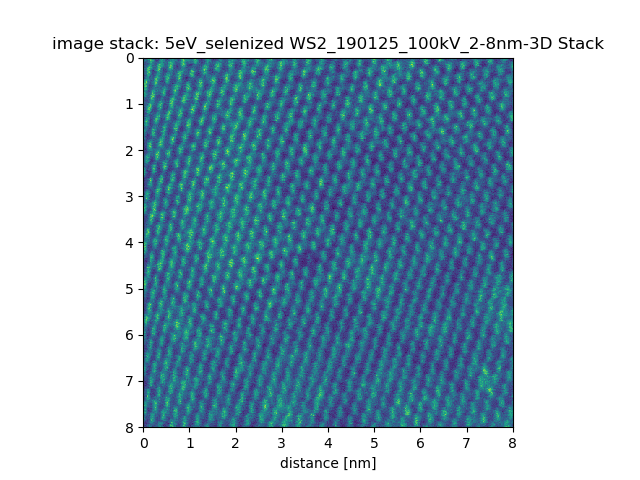

In [2]:
# Load file
#h5_file.close()
h5_file = ft.h5open_file()#os.path.join(current_directory,filename))
current_channel = h5_file['Measurement_000/Channel_000']

if current_channel['data_type'][()] != 'image_stack':
    print(f"Please load an image stack for this notebook, this is an {current_channel['data_type'][()]}")
    
ft.plt_pyUSID(current_channel)



## Input stack data
We put all the input data into a dictionary named tags

In [42]:
 ## spatial data
tags = {}
tags['sizeX'] = current_channel['spatial_size_x'][()]
tags['sizeY'] = current_channel['spatial_size_y'][()]
tags['scaleX'] = current_channel['spatial_scale_x'][()]
tags['scaleY'] = current_channel['spatial_scale_y'][()]
tags['extent'] = (0,tags['sizeX']*tags['scaleX'],tags['sizeY']*tags['scaleY'],0)
if 'image_stack' in current_channel:
    tags['image_stack'] = current_channel['image_stack'][()] 
     

# Registration

If this is an image stack we need to register and add the images. 

If this is not an image stack, we just take whatever image you opened.


Image stack
Stack contains  20  images, each with 512  pixels in the x-direction and  512  pixels in the y-direction
Image number 0  xshift =  -0.079  y-shift = 0.159
Image number 1  xshift =  -0.026  y-shift = -2.659
Image number 2  xshift =  -0.007  y-shift = -2.148
Image number 3  xshift =  0.013  y-shift = -6.519
Image number 4  xshift =  0.034  y-shift = -14.352
Image number 5  xshift =  -0.024  y-shift = 0.238
Image number 6  xshift =  -0.115  y-shift = 5.306
Image number 7  xshift =  -0.094  y-shift = 6.396
Image number 8  xshift =  -0.058  y-shift = 4.367
Image number 9  xshift =  -0.065  y-shift = 0.247
Image number 10  xshift =  -0.001  y-shift = -0.001
Image number 11  xshift =  0.07  y-shift = -1.016
Image number 12  xshift =  0.061  y-shift = -3.996
Image number 13  xshift =  0.072  y-shift = -6.281
Image number 14  xshift =  0.094  y-shift = -6.758
Image number 15  xshift =  0.058  y-shift = -3.436
Image number 16  xshift =  -0.037  y-shift = 18.08
Image number 17  xshift

<IPython.core.display.Javascript object>


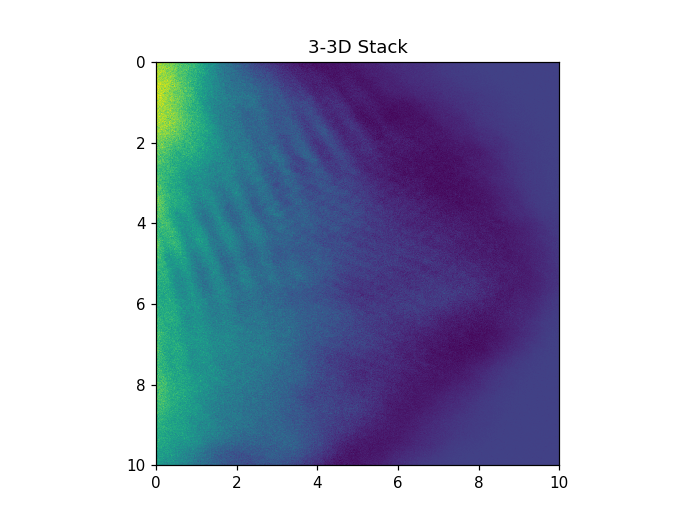

In [12]:
if 'image_stack' in tags:
    print('Image stack')
    out_tags = {}   
    data_cube = tags['image_stack']
    nopix = data_cube.shape[0]
    nopiy = data_cube.shape[1]
    nimages = data_cube.shape[2]

    print('Stack contains ',nimages,' images, each with',nopix,' pixels in the x-direction and ', nopiy,' pixels in the y-direction')

    stack = np.transpose(data_cube, axes=(1,0,2) )
    
    RigReg ,drift = it.dftRigReg(stack)
    image_boundaries = it.CropImage(drift[:], stack.shape, verbose = False)

    [xpmin,xpmax,ypmin,ypmax] = image_boundaries

    print()        
    print ('Cropped area ranges',xpmin,':',xpmax, ' in the x-direction')         
    print ('Cropped area ranges',ypmin,':',ypmax, ' in the y-direction')   
    ixrange = xpmax-xpmin + 1 
    iyrange = ypmax-ypmin + 1
    print('Which results in a cropped image',ixrange,' pixels in the x direction and',iyrange, 'pixel in the y-direction' )
    RigReg_crop = RigReg[ypmin:ypmax+1, xpmin:xpmax+1,:] # Note we only use the images with continuous drift

    RigReg_image = np.sum(RigReg_crop, axis=2)
    size = np.min(RigReg_image.shape)
    im = RigReg_image[0:size,0:size]
    
    out_tags['Rigid_registration_stack']=RigReg_crop
    out_tags['Rigid_registration_drift']=drift
    out_tags['data']=im
    
else:
    
    data = current_channel['Raw_Data'][()]
    im = np.reshape(data, [tags['sizeX'], tags['sizeY']])
    
plt.figure()
plt.title(current_channel['title'][()] )
plt.imshow(im,extent = tags['extent'], origin = 'upper');

## Log Rigid Registration

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ Rigid_registration_drift
      ├ Rigid_registration_stack
      ├ _rigid_registration
      ├ analysis
      ├ data
      ├ extent
      ├ notebook
      ├ notebook_version
      ├ spatial_origin_x
      ├ spatial_origin_y
      ├ spatial_scale_x
      ├ spatial_scale_y
      ├ spatial_size_x
      ├ spatial_size_y
      ├ spatial_units
      ├ time_stamp
      ├ title
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ data_type
    ├ detector_type
    ├ image_mode
    ├ image_stack
    ├ image_type
    ├ original_metadata
      -----------------
    ├ seconds_per_pixel
    ├ spatial_scale_x
    ├ spatial_scale_y
    ├ spatial_size_x
    ├ spatial_size_y
    ├ spatial_units
    ├ title


<IPython.core.display.Javascript object>


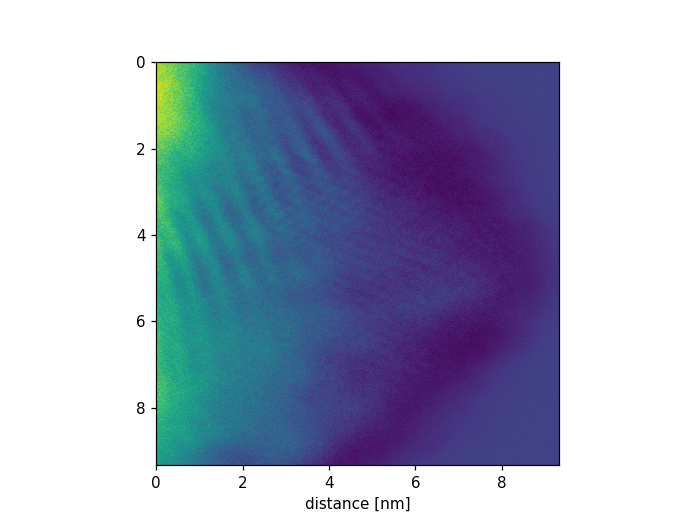

In [13]:

out_tags['analysis'] = 'Rigid Registration'
out_tags['notebook']= __notebook__ 
out_tags['notebook_version']= __notebook_version__

out_tags['data'] = im
out_tags['spatial_origin_x'] = 0.
out_tags['spatial_origin_y'] = 0.
out_tags['spatial_scale_x'] = current_channel['spatial_scale_x'][()]
out_tags['spatial_scale_y'] = current_channel['spatial_scale_y'][()]
out_tags['spatial_size_x'] = im.shape[0]
out_tags['spatial_size_y'] = im.shape[1]
out_tags['spatial_units'] = 'nm'


FOV_x = out_tags['spatial_size_x']* out_tags['spatial_scale_x']
FOV_y = out_tags['spatial_size_y']* out_tags['spatial_scale_y']
out_tags['extent'] = [0,FOV_x,FOV_y, 0]
name = 'rigid_registration'
log_group = ft.h5_add_Log(current_channel, name)
ft.h5_add_Data2Log(log_group,  out_tags)


usid.hdf_utils.print_tree(h5_file)


fig = plt.figure()
plt.imshow(out_tags['data'],origin='upper', extent = out_tags['extent'])
plt.xlabel('distance ['+ out_tags['spatial_units']+']');


(10, 2)


<IPython.core.display.Javascript object>


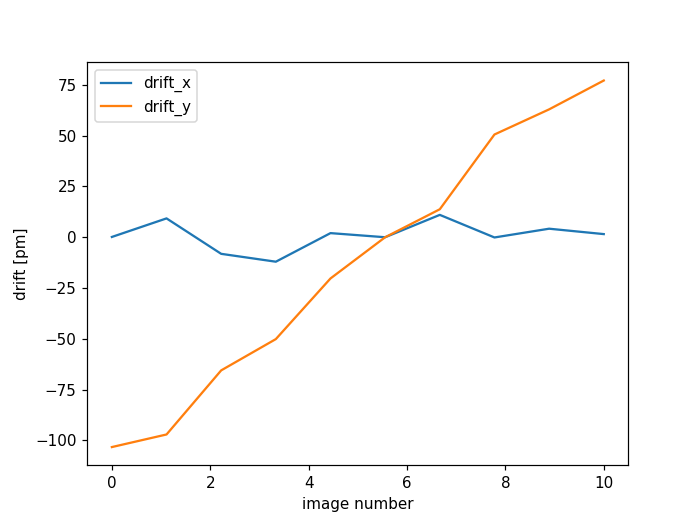

In [8]:
drift_data = current_channel['Log_000']['Rigid_registration_drift'][()]* current_channel['spatial_scale_x'][()]*1000

plt.figure()
plt.plot(np.linspace(0,drift_data.shape[0],drift_data.shape[0]), drift_data[:,0], label = 'drift_x')
plt.plot(np.linspace(0,drift_data.shape[0],drift_data.shape[0]), drift_data[:,1], label = 'drift_y')
plt.xlabel('image number')
plt.ylabel('drift [pm]')
plt.legend();

## Non-Rigid Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by the  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

image  0
image  1
image  2
image  3
image  4
image  5
image  6
image  7
image  8
image  9
:-)
You have succesfully completed Diffeomorphic Demons Registration


<IPython.core.display.Javascript object>


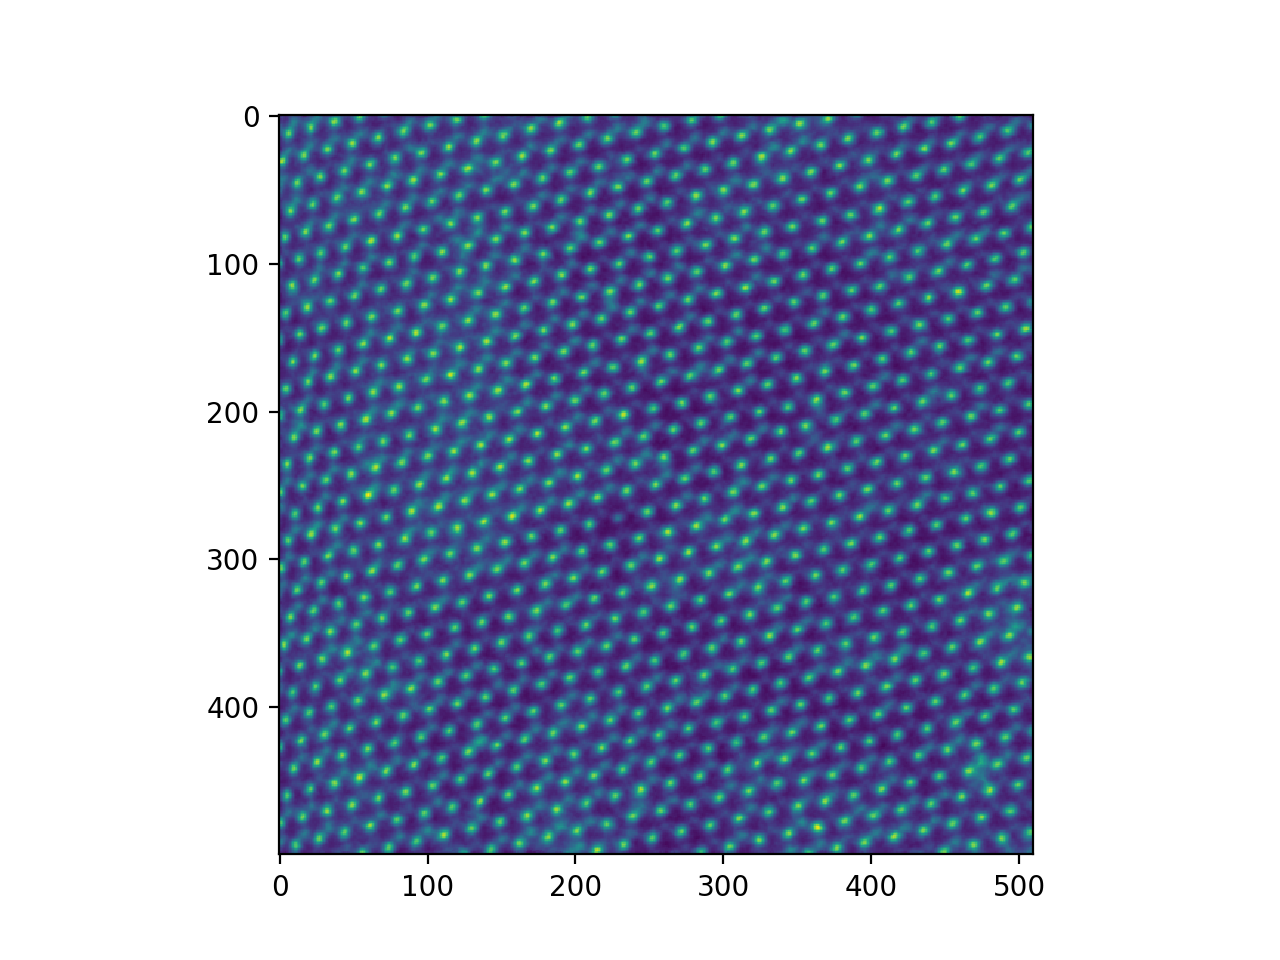

In [17]:

non_rigid_registered = it.DemonReg(RigReg_crop)

DemReg_image = np.sum(non_rigid_registered, axis=2)

plt.figure()
plt.imshow(DemReg_image);

In [10]:
def DemonReg(cube, verbose = False):
    
    DemReg =  np.zeros_like(cube)
    nimages = cube.shape[2]
    # create fixed image by summing over rigid registration

    fixed_np = np.sum(cube, axis=2)/float(nimages)

    fixed = sitk.GetImageFromArray(fixed_np)
    fixed = sitk.DiscreteGaussian(fixed, 2.0)

    demons = sitk.SymmetricForcesDemonsRegistrationFilter()
    #demons = sitk.DiffeomorphicDemonsRegistrationFilter()

    demons.SetNumberOfIterations(200)
    demons.SetStandardDeviations(1.0)

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed);
    resampler.SetInterpolator(sitk.sitkGaussian)
    resampler.SetDefaultPixelValue(0)

    for i in range(nimages):
        moving = sitk.GetImageFromArray(cube[:,:,i])
        movingf = sitk.DiscreteGaussian(moving, 2.0)
        displacementField = demons.Execute(fixed,movingf)
        outTx = sitk.DisplacementFieldTransform( displacementField )
        resampler.SetTransform(outTx)
        out = resampler.Execute(moving)
        DemReg[:,:,i] = sitk.GetArrayFromImage(out)
        print('image ', i)
        
    
    print(':-)')
    print('You have succesfully completed Diffeomorphic Demons Registration')
    
    return DemReg

(500, 510, 10)
image  0
image  1
image  2
image  3
image  4
image  5
image  6
image  7
image  8
image  9
:-)
You have succesfully completed Diffeomorphic Demons Registration


<IPython.core.display.Javascript object>


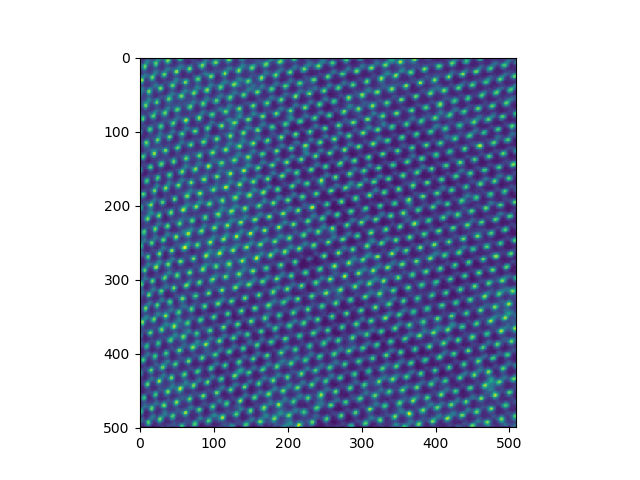

In [11]:
## import SimpleITK as sitk
import SimpleITK as sitk
cube = current_channel['Log_000']['Rigid_registration_stack'][()]
print(cube.shape)

non_rigid_registered = DemonReg(cube)

DemReg_image = np.sum(non_rigid_registered, axis=2)

plt.figure()
plt.imshow(DemReg_image);

## Log Non-Rigid Registration

please note that you can always delete a **Log** group with:<br>
*del current_channel['Log_001']*

Log_000 includes analysis: Rigid Registration
Log_001 includes analysis: Non-Rigid Registration


<IPython.core.display.Javascript object>


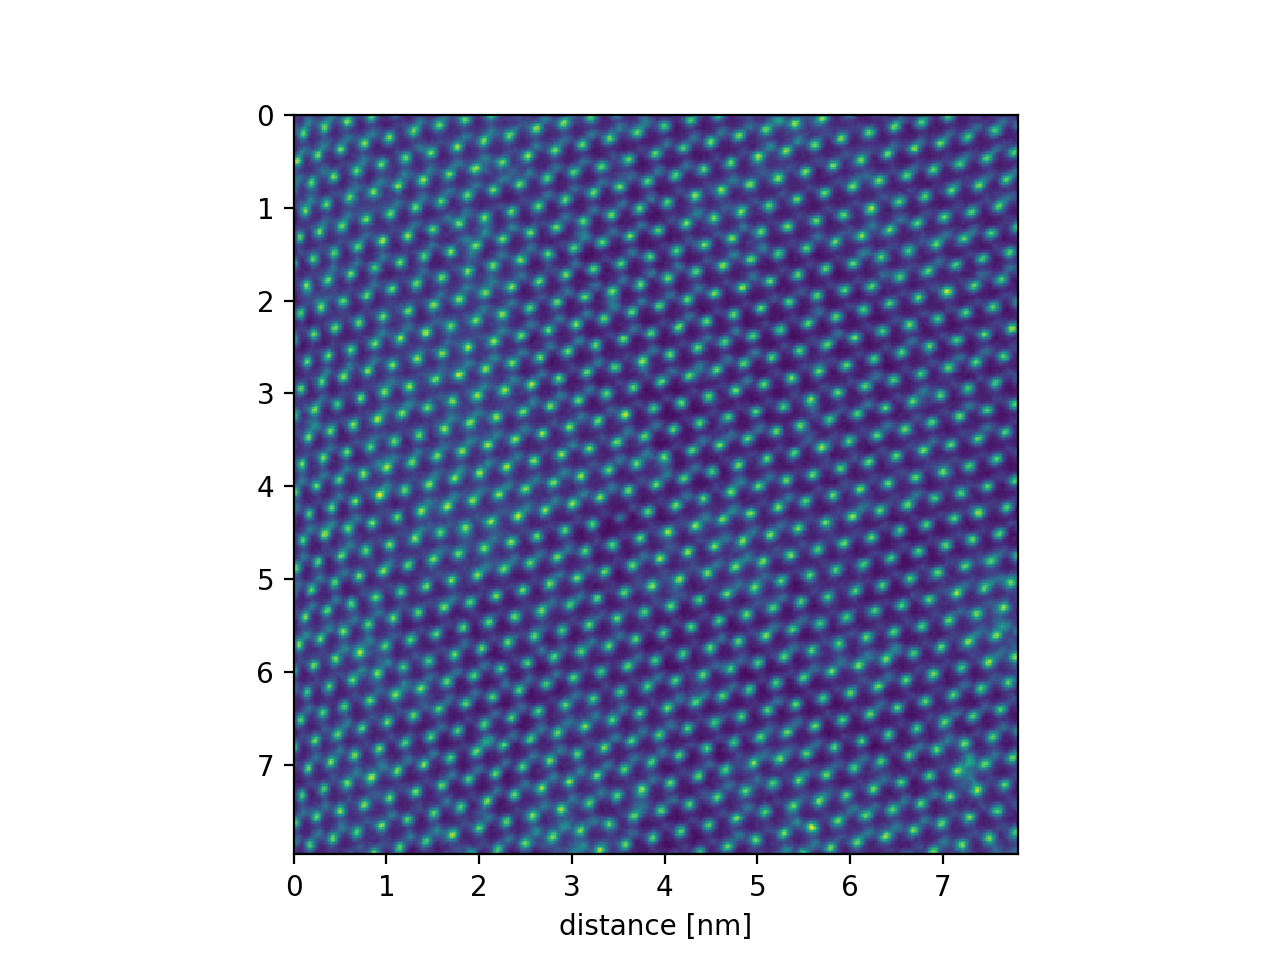

In [29]:
out_tags={}

out_tags['analysis']= 'Non-Rigid Registration'
out_tags['notebook']= __notebook__ 
out_tags['notebook_version']= __notebook_version__

out_tags['data'] = np.sum(non_rigid_registered, axis=2)
out_tags['Non_Rigid_registration_stack']=non_rigid_registered
    
out_tags['spatial_origin_x'] = 0.
out_tags['spatial_origin_y'] = 0.
out_tags['spatial_scale_x'] = current_channel['spatial_scale_x'][()]
out_tags['spatial_scale_y'] = current_channel['spatial_scale_y'][()]
out_tags['spatial_size_x'] = DemReg_image.shape[0]
out_tags['spatial_size_y'] = DemReg_image.shape[1]
out_tags['spatial_units'] = 'nm'

FOV_x = out_tags['spatial_size_x']* out_tags['spatial_scale_x']
FOV_y = out_tags['spatial_size_y']* out_tags['spatial_scale_y']
out_tags['extent'] = [0,FOV_x,FOV_y, 0]
name = 'non-rigid_registration'
log_group = ft.h5_add_Log(current_channel, name)
ft.h5_add_Data2Log(log_group, out_tags)

for key in current_channel:
    if 'Log' in key:
        if 'analysis' in current_channel[key]:
            print(f"{key} includes analysis: {current_channel[key]['analysis'][()]}")

fig = plt.figure()
plt.imshow(out_tags['data'],origin='upper', extent = out_tags['extent'])
plt.xlabel('distance ['+ out_tags['spatial_units']+']');


# Close File



In [45]:
h5_file.close()

You can open this file now in the [Find atom positions](CH3-Find_Atoms.ipynb) notebook.  